## Implementation of a Generative Adversarial Network with Mnist data

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
iter: 2000 cost of discriminator 0.3757931 cost of generator 2.327367
iter: 3000 cost of discriminator 0.59264153 cost of generator 2.268923
iter: 4000 cost of discriminator 0.7067015 cost of generator 2.448505
iter: 5000 cost of discriminator 0.6334806 cost of generator 2.0213757
iter: 6000 cost of discriminator 0.46668434 cost of generator 2.53869
iter: 7000 cost of discriminator 0.70404875 cost of generator 2.3153837
iter: 8000 cost of discriminator 0.6116177 cost of generator 2.351711
iter: 9000 cost of discriminator 0.6478527 cost of gene

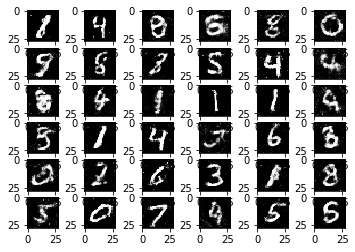

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The dimension of the Prior Noise Signal is 100 
## The generator would have 150 and 300 hidden units successively before 784 outputs corresponding
## to 28x28 image size

h1_dim = 150
h2_dim = 300
dim = 100
batch_size = 256

#-------------------------------------------------------------
# Define the generator - take noise and convert them to images
#--------------------------------------------------------------
def generator_(z_noise):
    w1 = tf.Variable(tf.truncated_normal([dim,h1_dim], stddev=0.1), name="w1_g", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h1_dim]), name="b1_g", dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(z_noise, w1) + b1)
    w2 = tf.Variable(tf.truncated_normal([h1_dim,h2_dim], stddev=0.1), name="w2_g", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h2_dim]), name="b2_g", dtype=tf.float32)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    w3 = tf.Variable(tf.truncated_normal([h2_dim,28*28],stddev=0.1), name="w3_g", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([28*28]), name="b3_g", dtype=tf.float32)
    h3 = tf.matmul(h2, w3) + b3
    out_gen = tf.nn.tanh(h3)
    weights_g = [w1, b1, w2, b2, w3, b3]
    return out_gen,weights_g

#-------------------------------------------------------------------------
# Define the Discriminator - take both real images  and synthetic fake images 
# from Generator and classify the real and fake images properly
#---------------------------------------------------------------------------
def discriminator_(x,out_gen,keep_prob):
    x_all = tf.concat([x,out_gen], 0)
    w1 = tf.Variable(tf.truncated_normal([28*28, h2_dim], stddev=0.1), name="w1_d", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h2_dim]), name="b1_d", dtype=tf.float32)
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_all, w1) + b1), keep_prob)
    w2 = tf.Variable(tf.truncated_normal([h2_dim, h1_dim], stddev=0.1), name="w2_d", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h1_dim]), name="b2_d", dtype=tf.float32)
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1,w2) + b2), keep_prob)
    w3 = tf.Variable(tf.truncated_normal([h1_dim, 1], stddev=0.1), name="w3_d", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([1]), name="d_b3", dtype=tf.float32)
    h3 = tf.matmul(h2, w3) + b3
    y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0], [batch_size, -1], name=None))
    y_fake = tf.nn.sigmoid(tf.slice(h3, [batch_size, 0], [-1, -1], name=None))
    weights_d = [w1, b1, w2, b2, w3, b3]
    return y_data,y_fake,weights_d



# Read the MNIST datadet
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
## Place holder for the real images
x = tf.placeholder(tf.float32, [batch_size, 28*28], name="x_data")
## Place holder for the noise
z_noise = tf.placeholder(tf.float32, [batch_size,dim], name="z_prior")
## Dropout probability
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
# generate the output op for generator and also define the weights.
out_gen,weights_g = generator_(z_noise)
# Define the ops and weights for Discriminator
y_data, y_fake,weights_d = discriminator_(x,out_gen,keep_prob)
## Cost function for Discriminator
discr_loss = -1*tf.reduce_mean(tf.log(y_data) + tf.log(1 - y_fake))
## Cost function for Generator
gen_loss = -1*tf.reduce_mean( tf.log(y_fake))
optimizer = tf.train.AdamOptimizer(0.0001)
d_trainer = optimizer.minimize(discr_loss,var_list=weights_d)
g_trainer = optimizer.minimize(gen_loss,var_list=weights_g)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess = tf.Session()
sess.run(init)
z_sample = np.random.uniform(-1, 1, size=(batch_size,dim)).astype(np.float32)

for i in range(60000):
    batch_x, _ = mnist.train.next_batch(batch_size)
    x_value = 2*batch_x.astype(np.float32) - 1
    z_value = np.random.uniform(-1, 1, size=(batch_size,dim)).astype(np.float32)
    sess.run(d_trainer,feed_dict={x:x_value, z_noise:z_value,keep_prob:0.7})
    sess.run(g_trainer,feed_dict={x:x_value, z_noise:z_value,keep_prob:0.7})
    if (i % 1000 == 0) and(i > 1000):
        c1,c2 = sess.run([discr_loss,gen_loss],feed_dict={x:x_value, z_noise:z_value,keep_prob:0.7})
        print ('iter:',i,'cost of discriminator',c1, 'cost of generator',c2)
out_val_img = sess.run(out_gen,feed_dict={z_noise:z_sample})     
img = 0.5*(out_val_img[3,:] + 1)
img = np.reshape(img,(28,28))
plt.imshow(img*255)
saver.save(sess, "newgan_",global_step=i)
imgs = 0.5*(out_val_img + 1)
for k in range(36):
    plt.subplot(6,6,k+1)
    image = np.reshape(imgs[k],(28,28))
    plt.imshow(image,cmap='gray')
   

 